# Gradient Boosting Machine (GBM)

After implementing decision trees, we can now move on to the next step: ensemble methods. In this notebook, we will implement the Gradient Boosting Machine (GBM) algorithm from scratch.

Both decision trees and GBM are local modes, compared to global models like linear regression. This kind of models need less assumptions about the data, and can capture complex patterns in the data. However, they are more prone to overfitting and require more tuning. Sometimes, it is not easy to scale them to large datasets. But recent models like XGBoost, LightGBM, and CatBoost have made it possible to train GBM on large datasets and achieve state-of-the-art performance.

Let's learn and implement GBM from scratch (not by inventing the whole universe first, but by using the tools we have already implemented).

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as stats
from sklearn.tree import DecisionTreeRegressor
sns.set()

## Simulate some data

As an experienced machine learning engineer, you should be aware that it is very common that the dataset does not follow the linear relationship. Very often, we have skewed data, outliers, and non-linear relationships. Let's simulate some data that does not follow the linear relationship.

The following figure shows a flattened pattern of the data, which is very common in real-world datasets.

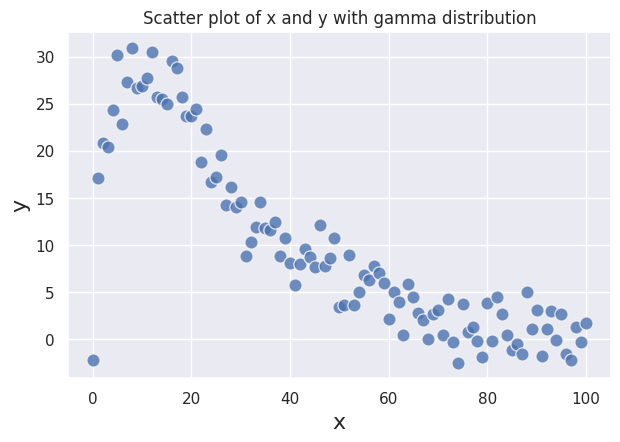

In [2]:
np.random.seed(123)
x = np.linspace(0, 100, 101)
# generating y using gamma distribution
y = (stats.gamma.pdf(x, a=1.5, loc=0, scale=17) + np.random.normal(0,0.002,101)) * 1000
x = x.reshape(-1,1)

fig, ax = plt.subplots(1, 1, figsize=(7, 4.5))
ax.scatter(x, y, edgecolors='whitesmoke', s=90, alpha=0.8)
ax.set_title('Scatter plot of x and y with gamma distribution')
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
fig.show()

Suppose we have a simple model that will predict the target variable `y` by calculating the mean value of `y` for all the samples in the training set. The following figure shows the mean value of `y` for each feature value. The mean value of `y` is shown by the red line.

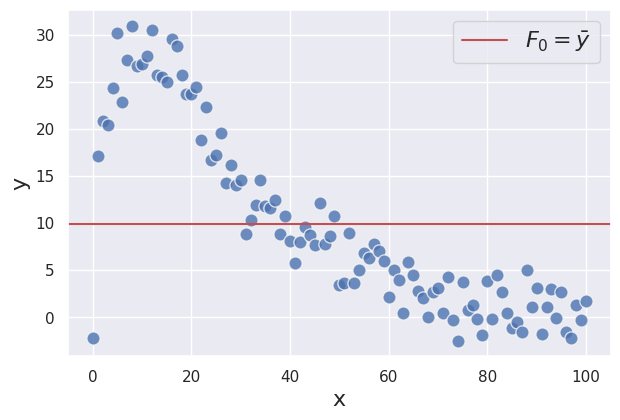

In [3]:
plt.figure(figsize=(7, 4.5))
plt.scatter(x, y, edgecolors='whitesmoke', s=90, alpha=0.8)
plt.axhline(y=y.mean(), color='r', linestyle='-', label=r'$F_{0} = \bar{y}$')
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.legend(fontsize=16)
plt.show()

Clearly, we are not happy with the performance of this model. Therefore, we want to build more models that can capture the non-linear relationship in the data. Let's index our first model as $F_0$. We have:

$$F_0(x) = \bar{y}$$

where $\bar{y}$ is the mean value of `y` in the training set.

Now, we will calculate the residuals of the first model. The residuals are the difference between the actual value of `y` and the predicted value of `y` by the model. We will use these residuals to build the next model. The residuals are shown in the following figure.

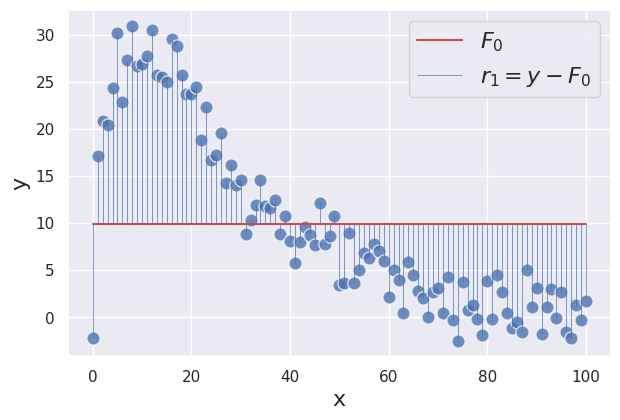

In [4]:
def plot_residuals(x, y, Fm, i, ax, title = ""):
    
    fltr_smaller = y < Fm
    fltr_bigger = y >= Fm

    ax.scatter(x, y, edgecolors='whitesmoke', s=90, alpha=0.8)
    ax.plot(x, Fm, c='r', label=f'$F_{i}$')
    ax.vlines(x[fltr_smaller], y[fltr_smaller], Fm[fltr_smaller], linewidth=0.5, color='b', label=f'$r_{i+1} = y - F_{i}$')
    ax.vlines(x[fltr_bigger], Fm[fltr_bigger], y[fltr_bigger], linewidth=0.5, color='b')
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('x', fontsize=16)
    ax.set_ylabel('y', fontsize=16)
    ax.legend(fontsize=16)
    
fig, ax = plt.subplots(1, 1, figsize=(7, 4.5))
F0 = np.full(len(y), y.mean())
plot_residuals(x, y, F0, 0, ax)
plt.show()

Now we want another model $h_1(x)$ that can predict the residuals of the first model. We will add this model to the first model to get a better prediction.

| Model | Features | Target |
|-------|----------|--------|
| $F_0(x)$ | $x$ | $y$ |
| $h_1(x)$ | $x$ | $y - F_0(x)$ |

To construct $h_1(x)$ we will use the decision tree algorithm. The idea is to split the data into two parts, such that the residuals of the first model are minimized. The following figure shows the residuals of the first model and the split of the data by the decision tree algorithm.

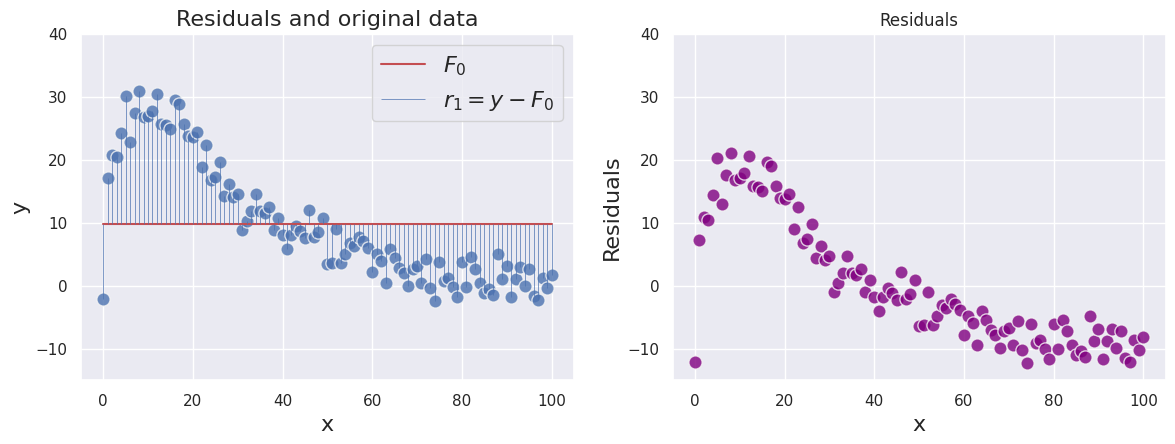

In [10]:
# plot residuals and original data side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 4.5))
plot_residuals(x, y, F0, 0, axes[0], title='Residuals and original data')
# set y limit from -15 to 60
axes[0].set_ylim(-15, 40)
residuals = y - F0
axes[1].scatter(x, residuals, edgecolors='whitesmoke', s=90, alpha=0.8, c='purple')
axes[1].set_title('Residuals')
axes[1].set_xlabel('x', fontsize=16)
axes[1].set_ylabel('Residuals', fontsize=16)
# set y limit from -15 to 60
axes[1].set_ylim(-15, 40)
plt.show()


In [6]:
# we will use the decision tree we built in the previous section
class DecisionTree:
    
    def __init__(self, X: pd.DataFrame, y: pd.Series,
                 min_samples_leaf: int = 5,
                 max_depth: int = 6,
                 idxs: np.ndarray = None):
        assert max_depth >= 0
        assert min_samples_leaf > 0
        self.min_samples_leaf, self.max_depth = min_samples_leaf, max_depth
        if isinstance(y, pd.Series):
            y = y.values
        if idxs is None:
            idxs = np.arange(len(y))
        self.X, self.y, self.idxs = X, y, idxs
        self.n, self.m = len(idxs), X.shape[1]
        # value of the node is the mean of y
        self.value = np.mean(y[idxs])
        self.best_score_so_far = float('inf') # initial loss before split finding
        
        if self.max_depth > 0:
            self._maybe_insert_child_nodes()
            
    @property
    def is_leaf(self):
        return self.best_score_so_far == float('inf')
    
    def _maybe_insert_child_nodes(self):
        for j in range(self.m):
            # there exist a better split for feature j
            # such as value < 50 for color red in our example
            # we will implement this method later
            self._find_better_split(j)
        if self.is_leaf:
            # no need to create child nodes
            return
        x = self.X.values[self.idxs, self.split_feature_idx]
        # get the indexes of the samples that are less than 
        # or equal to the split value
        # this step is to sort the samples to the left and right nodes
        left_idx = np.nonzero(x <= self.threshold)[0]
        right_idx = np.nonzero(x > self.threshold)[0]
        self.left = DecisionTree(self.X, self.y, self.min_samples_leaf, self.max_depth - 1, self.idxs[left_idx])
        self.right = DecisionTree(self.X, self.y, self.min_samples_leaf, self.max_depth - 1, self.idxs[right_idx])
        
    def _score(self, sum_y_left, n_left, sum_y_right, n_right, sum_y, n):
        score = -(sum_y_left ** 2) / n_left - (sum_y_right ** 2) / n_right + (sum_y ** 2) / n
        return score

    def _find_better_split(self, feature_idx):
        x = self.X.values[self.idxs, feature_idx]
        y = self.y[self.idxs]
        # we sort the samples by the feature values
        # this will help us to pin down the threshold values
        sort_idx = np.argsort(x)
        sort_y, sort_x = y[sort_idx], x[sort_idx]
        sum_y, n = sort_y.sum(), len(sort_y)
        sum_y_right, n_right = sum_y, n
        sum_y_left, n_left = 0, 0
        
        for i in range(0, self.n - self.min_samples_leaf):
            xi, xi_next, yi = sort_x[i], sort_x[i + 1], sort_y[i]
            sum_y_left += yi
            sum_y_right -= yi
            n_left += 1
            n_right -= 1
            if n_left < self.min_samples_leaf or xi == xi_next:
                # continue to search for the next split
                continue
            score = self._score(sum_y_left, n_left, sum_y_right, n_right, sum_y, n)
            
            if score < self.best_score_so_far:
                self.best_score_so_far = score
                self.split_feature_idx = feature_idx
                self.threshold = (xi + xi_next) / 2

                
    def __repr__(self):
        s = f'n: {self.n}; value: {self.value:.2f}'
        if not self.is_leaf:
            split_feature_name = self.X.columns[self.split_feature_idx]
            s += f'; split_feature: {split_feature_name} <= {self.threshold:.2f}'
        return s
    
    def predict(self, X):
        return np.array([self._predict_row(xi) for xi in X.values]) 

    def _predict_row(self, xi):
        if self.is_leaf:
            return self.value
        t = self.left if xi[self.split_feature_idx] <= self.threshold else self.right
        return t._predict_row(xi)

In [7]:
# check F0, the model we have built above
F0[:3]

array([9.85516696, 9.85516696, 9.85516696])

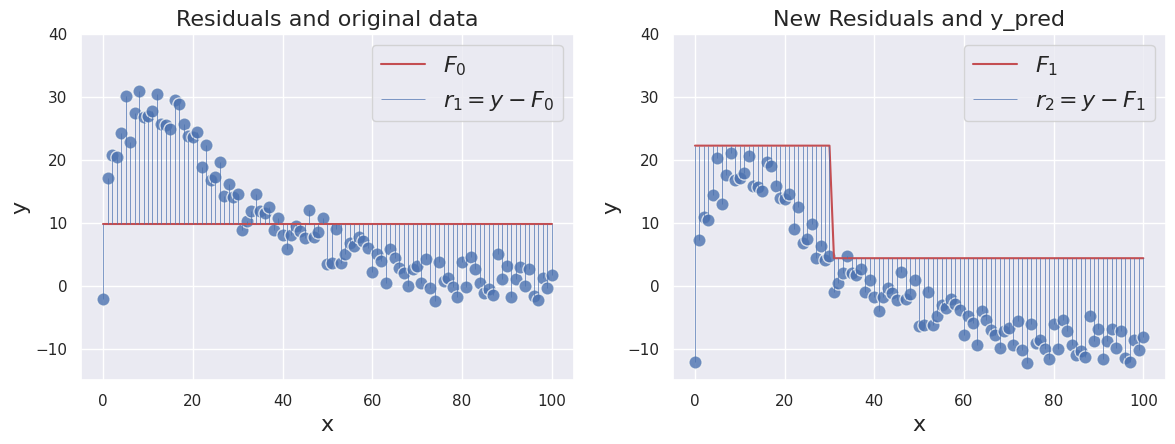

In [11]:
tree = DecisionTree(pd.DataFrame(x, columns=['x']), pd.Series(y), max_depth=1)
y_pred = tree.predict(pd.DataFrame(x, columns=['x']))

# plot residuals and y_pred
fig, axes = plt.subplots(1, 2, figsize=(14, 4.5))
plot_residuals(x, y, F0, 0, axes[0], title='Residuals and original data')
# set y limit from -15 to 60
axes[0].set_ylim(-15, 40)
plot_residuals(x, residuals, y_pred, 1, axes[1], title='New Residuals and y_pred')
# set y limit from -15 to 60
axes[1].set_ylim(-15, 40)
plt.show()

You can see that we are able to get a better prediction by adding the second model to the first model. Until now, we have

$$F_1(x) = F_0(x) + h_1(x)$$

| Model | Features | Target |
|-------|----------|--------|
| $F_0(x)$ | $x$ | $y$ |
| $h_1(x)$ | $x$ | $y - F_0(x)$ |

We can follow this process to build more models:

$$F_M(x) = F_0(x) + \sum_{m=1}^{M} h_m(x)$$

where $M$ is the number of models we want to build.

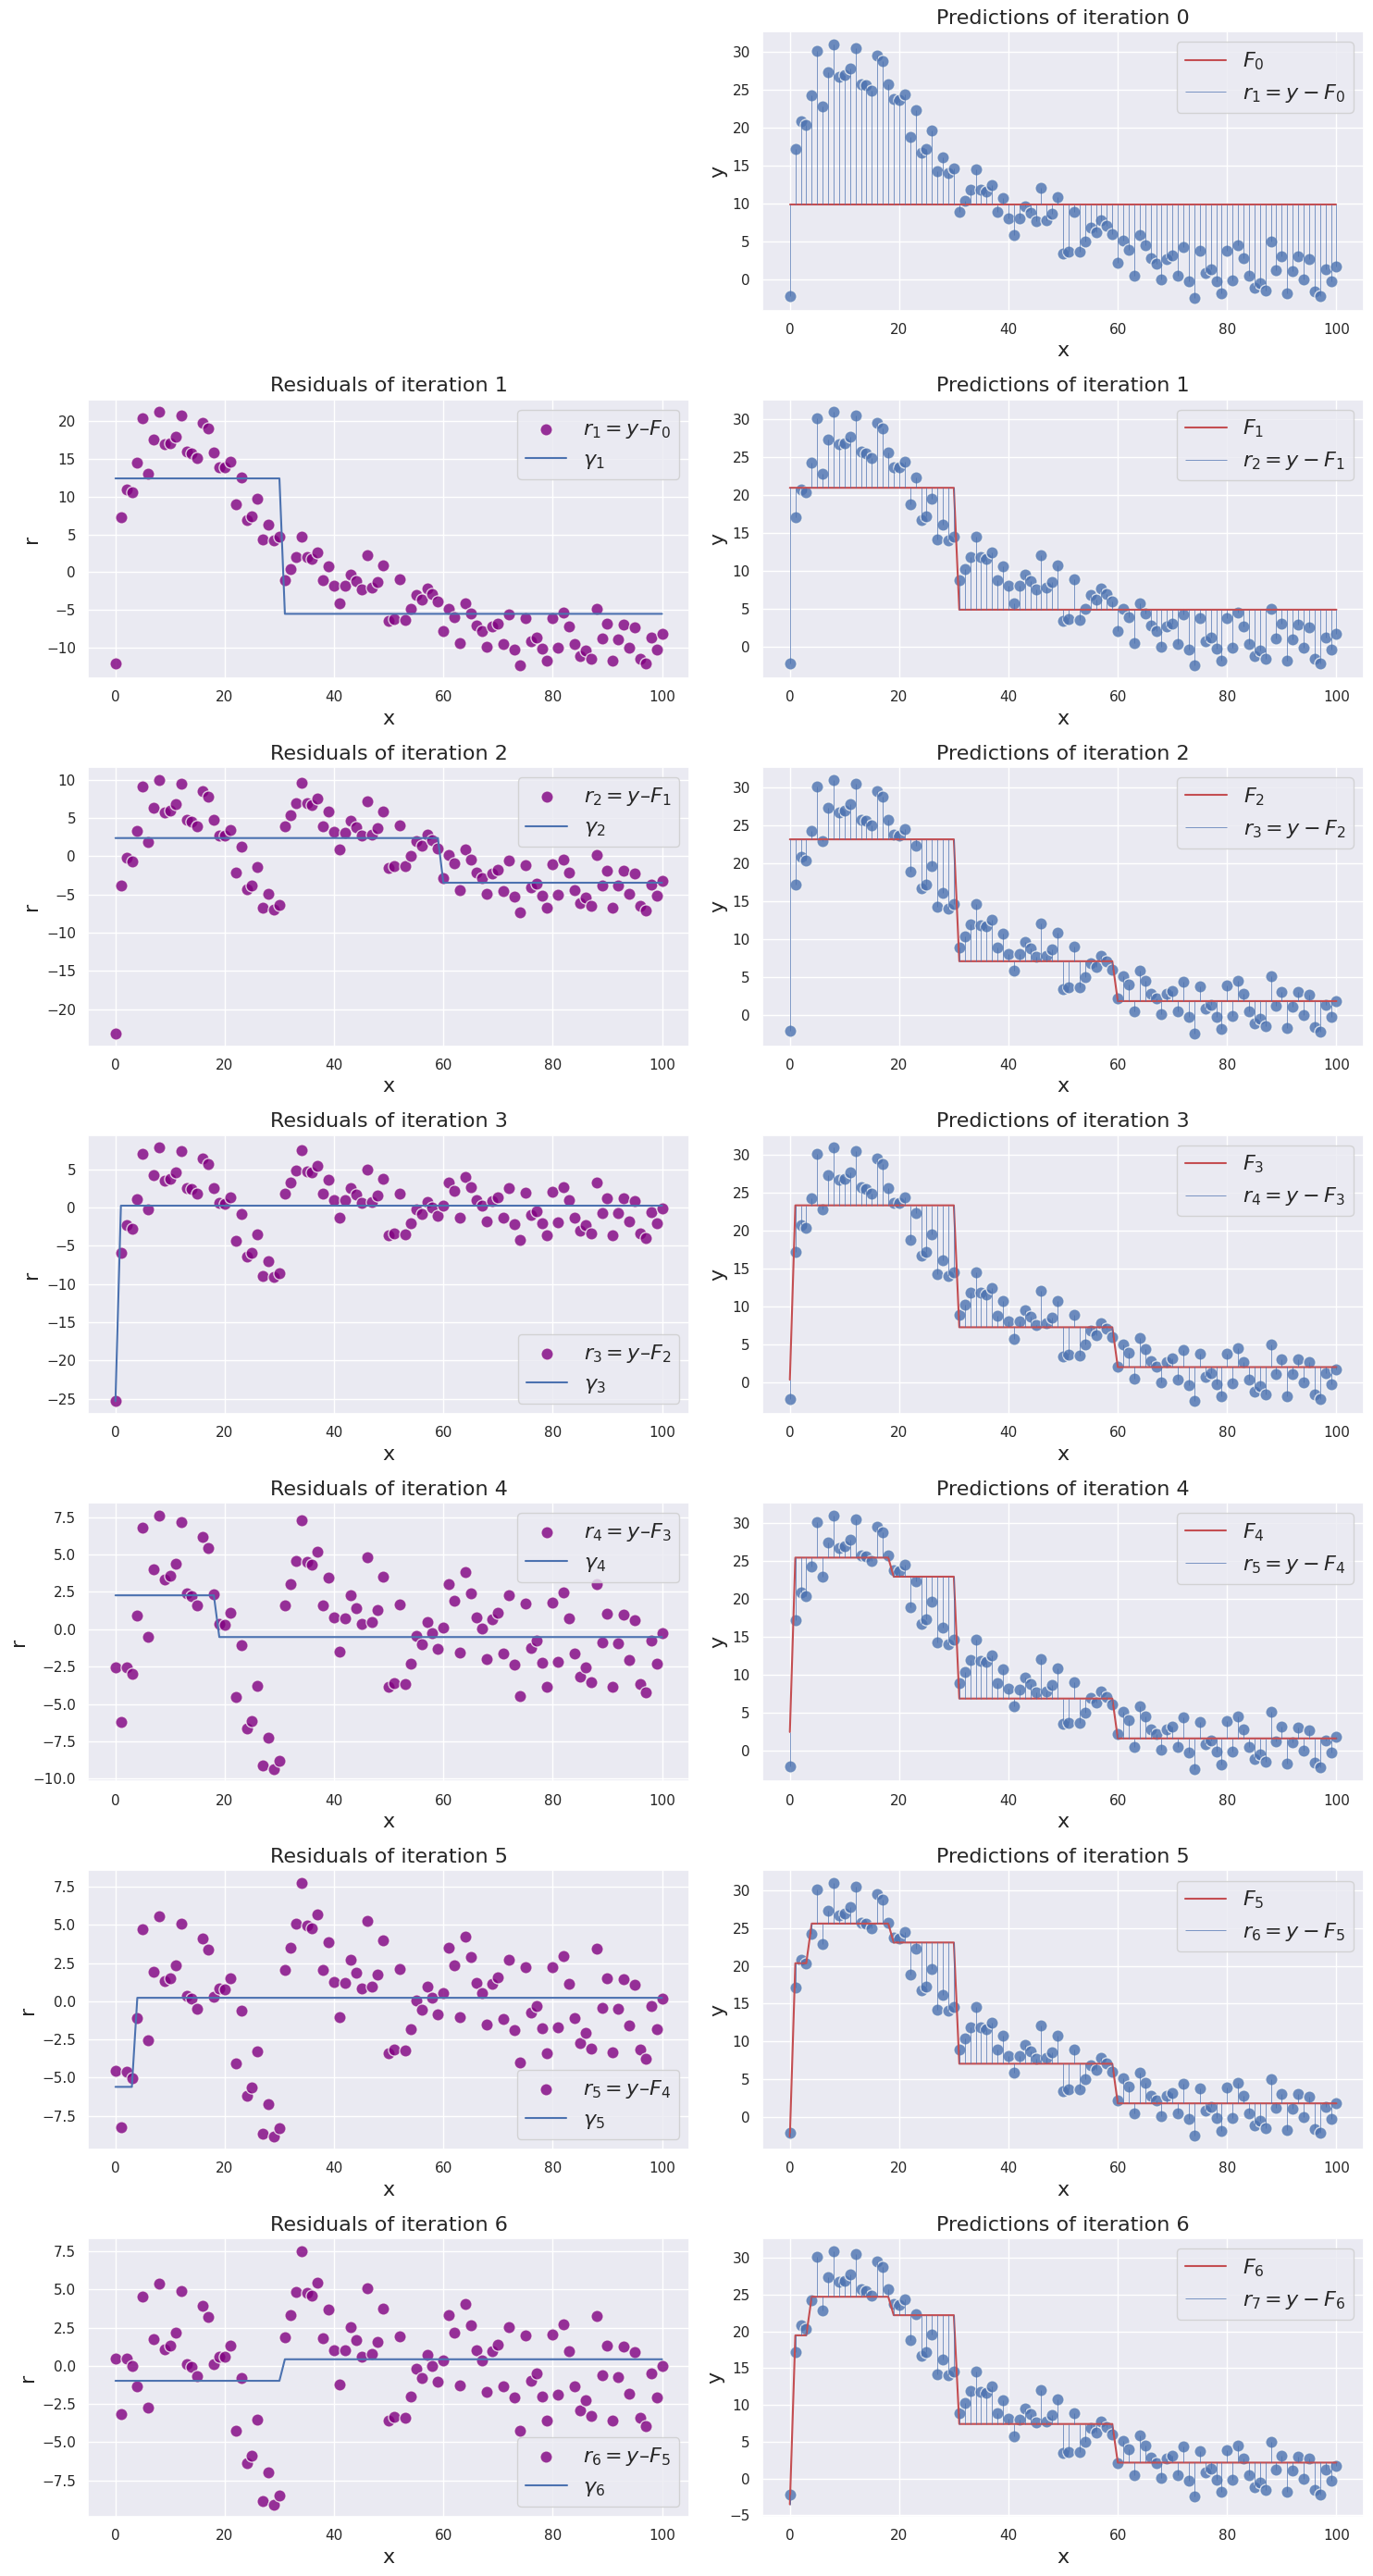

In [13]:
def train_and_update(x, y, Fm, learing_rate=0.1):
    
    r = y - Fm
    tree = DecisionTreeRegressor(max_depth=1, random_state=0)
    tree.fit(x, r)
    gamma = tree.predict(x)
    Fm = Fm + learing_rate * gamma
    
    return tree, Fm, gamma, r


def plot_gamma(x, residuals, gamma, i, ax, title = ""):
    
    ax.scatter(x, residuals, edgecolors='whitesmoke', color = 'purple', s=90, alpha=0.8, label=f'$r_{i} = y – F_{i-1}$')
    ax.plot(x, gamma, c='b', label=f'$γ_{i}$')
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("x", fontsize=16)
    ax.set_ylabel("r", fontsize=16)
    ax.legend(fontsize=16)


Fm = F0 = np.full(len(y), y.mean())
n_estimators = 6

fig, axs = plt.subplots(n_estimators+1, 2, figsize=(15, 4*(n_estimators+1)))
axs = axs.flatten()
axs[0].axis('off')

plot_residuals(x, y, F0, 0, axs[1], title="Predictions of iteration 0")

for i in range(n_estimators):
    tree, Fm, gamma, r = train_and_update(x, y, Fm, learing_rate=0.9)
    
    j = 2 + i*2
    plot_gamma(x, r, gamma, i+1, axs[j], f"Residuals of iteration {i+1}")
    plot_residuals(x, y, Fm, i+1, axs[j+1], title=f"Predictions of iteration {i+1}")
    
plt.tight_layout()
plt.show()

## Learning rate 

The learning rate is a hyperparameter that controls the contribution of each model to the final prediction. The learning rate is multiplied by the prediction of each model before adding it to the final prediction. The learning rate is a value between 0 and 1. A smaller learning rate will require more models to get a good prediction, but it will be more robust to overfitting.

Our model will be:

$$F_M(x) = F_0(x) +  \eta \sum_{m=1}^{M} h_m(x)$$

where $\eta$ is the learning rate.



## Gradient Boosting Machine (GBM)

In [14]:
class GBMFromScratch:
    
    def __init__(self, n_trees:int, learning_rate:int = 0.1, max_depth: int = 1):
        self.n_trees = n_trees
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        
    def fit(self, X, y):
        self.trees = []
        self.F0 = y.mean()
        Fm = self.F0
        for _ in range(self.n_trees):
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=0)
            tree.fit(X, y - Fm)
            Fm += self.learning_rate * tree.predict(X)
            self.trees.append(tree)
    
    def predict(self, X):
        Fm = self.F0
        for tree in self.trees:
            Fm += self.learning_rate * tree.predict(X)
        return Fm

In [15]:
# compare with sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

sklearn_gbm = GradientBoostingRegressor(n_estimators =25, learning_rate=0.3, max_depth=1)
sklearn_gbm.fit(x,y)

scratch_gbm = GBMFromScratch(n_trees=25, learning_rate=0.3, max_depth=1)
scratch_gbm.fit(x,y)

mean_squared_error(y, sklearn_gbm.predict(x)), mean_squared_error(y, scratch_gbm.predict(x))

(4.124361446086017, 4.124361446086017)